In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import requests
headers = {"content-type": "application/json"}

### load image and resize. The resize is optional. But bigger images takes longer to run

In [2]:
test_image = cv2.imread('test_images/img1.png')
test_image = cv2.resize(test_image, (1280, 720))

### When we load image using opencv, it's in BGR. We need to turn it into RGB

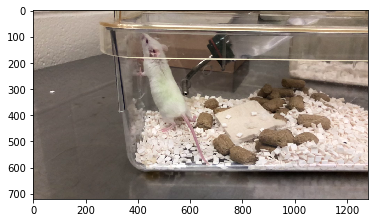

In [3]:
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
plt.imshow(test_image)

### Add extra dimmension as the model expects tensor of shape [1, -1, -1, 3]

In [4]:
test_images= np.expand_dims(test_image, 0)

### prepare for the query

In [5]:
data = json.dumps({"signature_name": "serving_default", "instances": test_image.tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... [151, 138, 135], [149, 136, 133], [149, 136, 133]]]}


### query the model prediction

In [6]:
json_response = requests.post('http://localhost:8501/v1/models/dlc:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
heatmap = np.array(predictions)

In [7]:
heatmap.shape

(1, 90, 160, 7)

### heatmap is the model prediction of the location of different body parts. 
each channel of heatmap represents the spatial probability distribution of one body part. We are tracking 7 parts:
0. left_ear
1. right_ear
2. left_hand
3. right_hand
4. left_foot
5. right_foot
6. tail_tip

Each channel has the same aspect ratio with the input image, but downscaled by a factor of 8. i.e (1920, 720) -> (160, 90)

if we plot the 3rd channel, we'll see the probabilty of left hand

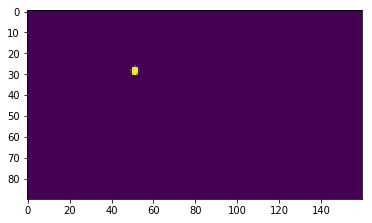

In [8]:
plt.imshow(heatmap[0,:,:,2])

To extract the location of left hand in the original image, we can take the argmax of the heatmap, and scale it back to the original resolution

In [9]:
left_hand_heatmap = heatmap[0,:,:,2]
left_hand_y, left_hand_x = np.unravel_index(np.argmax(left_hand_heatmap, axis=None), left_hand_heatmap.shape)
left_hand_y_full_res = left_hand_y * 8
left_hand_x_full_res = left_hand_x * 8

let's check the result

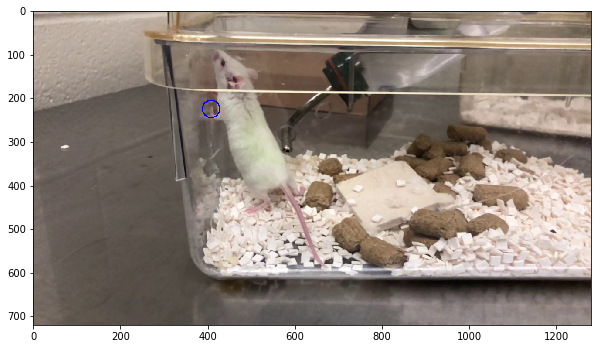

In [10]:
plt.figure(figsize=(10,6))
plt.imshow(
    cv2.circle(
        img = test_image, 
        center = (left_hand_x_full_res, left_hand_y_full_res),
        radius = 20,
        color = (0, 0, 255),
        thickness = 2,
    )
)